# Imports

In [39]:
import numpy as np
import itertools
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Introduction

Consider the following $p$-Laplacian equation:
$$\Delta_p \Psi(x,y)=-\pi ^2 (1-y) y \sin (\pi  x)-2 \sin (\pi  x)$$

$x \in [0,1],\ y \in [0,1]$ with *Dirichlet* BC: $\Psi(0,y) = 0$, $\Psi(1,y) = 0$, $\Psi(x,0) = 0$ and $\Psi(x,1) = 0$.

For this first attempt, we will take $p=2$.

# Defining functions

Sigmoid $\sigma(x) = \frac{1}{1+e^{-x}}$ and its derrivatives.

In [2]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def sig1(x):
    return sig(x) * (1 - sig(x))

def sig2(x):
    return sig1(x) - 2 * sig(x) * sig1(x)

def sig3(x):
    return sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

The right side of the equation:  $f(x,y) = -\pi ^2 (1-y) y \sin (\pi  x)-2 \sin (\pi  x)$

In [3]:
def f(x, y):
    return -np.pi**2 * (1-y) * y * np.sin(np.pi * x) - 2 * np.sin(np.pi * x)

The analytic solution is given by: $\Psi_a(x,y) = y (1-y) \sin(\pi  x)$

In [4]:
def psi_a(x, y):
    return y * (1-y) * np.sin(np.pi * x)

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [5]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\frac{\partial^k N}{\partial x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [6]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\frac{\partial N}{\partial w_j} = x_j v \sigma '$$

In [7]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [8]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [9]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \frac{\partial}{\partial u} \frac{\partial^k}{\partial x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [10]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \frac{\partial}{\partial v} \frac{\partial^k}{\partial x_j^k} N = w_j^k \sigma^{(k)} $$

In [11]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Trial solution

The trial solution is given by: $$\Psi_t(x,y) = x(1-x)y(1-y)N(x,y,\vec{p})$$

In [12]:
def psi_t(x, y, p):
    return x * (1-x) * y * (1-y) * N(x, y, p)

$$\frac{\partial^2 \Psi_t}{\partial x_j^2} = y_j(1-y_j)\left[ -2N + (2-4x_j) \frac{\partial N}{\partial x_j} + x_j (1-x_j) \frac{\partial^2 N}{\partial x_j^2} \right]$$

In [13]:
def dPsi2_dxj2(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return yj*(1-yj)*(-2*N(x,y,p) + (2-4*xj)*dN_dxj_k(x,y,p,j,1) + xj*(1-xj)*dN_dxj_k(x,y,p,j,2))

## Cost function

$$E[\vec{p}] = \sum_i \left\{ \frac{\partial \Psi_t(x_i,y_i)^2}{\partial x^2} + \frac{\partial \Psi_t(x_i,y_i)^2}{\partial y^2} - f(x_i,y_i) \right\}^2$$

In [14]:
def error(x, y, p):
    return dPsi2_dxj2(x, y, p, 0) + dPsi2_dxj2(x, y, p, 1) - f(x, y)

In [15]:
def cost(pairs, p):
    loss = []
    for x, y in pairs:
        err_sq = error(x, y, p)**2
        loss.append(err_sq)
    return sum(loss)

# Gradients

To find the gradients, we first need to find $\frac{\partial}{\partial w_j} \frac{\partial^2 \Psi_t}{\partial x_k^2}$ , $\frac{\partial}{\partial u} \frac{\partial^2 \Psi_t}{\partial x_k^2}$ and $\frac{\partial}{\partial v} \frac{\partial^2 \Psi_t}{\partial x_k^2}$ .

$$\frac{\partial}{\partial w_j} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial w_j} + (2-4x_k) \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [16]:
def d_dwj_dPsi2_dxk2(x, y, p, j, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*dN_dwj(x,y,p,j) + (2-4*xj)*d_dwj_dN_dxk(x,y,p,j,k) + xj*(1-xj)*d_dwj_dN2_dxk2(x,y,p,j,k))

$$\frac{\partial}{\partial u} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial u} + (2-4x_k) \frac{\partial}{\partial u} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [17]:
def d_du_dPsi2_dxk2(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*d_du_dkN(x,y,p,k,0) + (2-4*xj)*d_du_dkN(x,y,p,k,1) + xj*(1-xj)*d_du_dkN(x,y,p,k,2))

$$\frac{\partial}{\partial v} \frac{\partial^2 \Psi_t}{\partial x_k^2} = y_k(1-y_k)\left[ -2\frac{\partial N}{\partial v} + (2-4x_k) \frac{\partial}{\partial v} \frac{\partial N}{\partial x_k} + x_k(1-x_k) \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial x_k^2} \right]$$

In [18]:
def d_dv_dPsi2_dxk2(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*(-2*d_dv_dkN(x,y,p,k,0) + (2-4*xj)*d_dv_dkN(x,y,p,k,1) + xj*(1-xj)*d_dv_dkN(x,y,p,k,2))

$$ \frac{\partial E[\vec{p}]}{\partial w_j} = 2 \text{ (error) } \left( \frac{\partial}{\partial w_j} \frac{\partial \Psi_t^2}{\partial x^2} + \frac{\partial}{\partial w_j} \frac{\partial \Psi_t^2}{\partial y^2} \right) $$

In [19]:
def dE_dwj(x, y, p, j):
    return 2 * error(x,y,p) * (d_dwj_dPsi2_dxk2(x,y,p,j,0) + d_dwj_dPsi2_dxk2(x,y,p,j,1))

$$ \frac{\partial E[\vec{p}]}{\partial u} = 2 \text{ (error) } \left( \frac{\partial}{\partial u} \frac{\partial \Psi_t^2}{\partial x^2} + \frac{\partial}{\partial u} \frac{\partial \Psi_t^2}{\partial y^2} \right) $$

In [20]:
def dE_du(x, y, p):
    return 2 * error(x,y,p) * (d_du_dPsi2_dxk2(x,y,p,0) + d_du_dPsi2_dxk2(x,y,p,1))

$$ \frac{\partial E[\vec{p}]}{\partial v} = 2 \text{ (error) } \left( \frac{\partial}{\partial v} \frac{\partial \Psi_t^2}{\partial x^2} + \frac{\partial}{\partial v} \frac{\partial \Psi_t^2}{\partial y^2} \right) $$

In [21]:
def dE_dv(x, y, p):
    return 2 * error(x,y,p) * (d_dv_dPsi2_dxk2(x,y,p,0) + d_dv_dPsi2_dxk2(x,y,p,1))

# Training

### Initialization

In [22]:
nx = 10
dx = 1. / nx
points = (np.linspace(0, 1, nx), np.linspace(0, 1, nx))
pairs = list(itertools.product(points[0], points[1]))

p = [np.random.rand(2,10), np.random.rand(10), np.random.rand(10)]

### Stochastic Gradient Descent

In [ ]:
lr = 0.05
itr = 2000

err_rate = []


for i in range(itr):
    np.random.shuffle(pairs)
    for x, y in pairs: 
        p[0][0] -= lr * dE_dwj(x, y, p, 0)
        p[0][1] -= lr * dE_dwj(x, y, p, 1)
        p[1] -= lr * dE_du(x, y, p)
        p[2] -= lr * dE_dv(x, y, p)
    err_rate.append(cost(pairs, p))
    
print(cost(pairs,p))

# Graphs

### Error vs Iterations

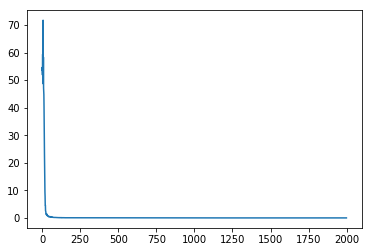

In [88]:
min_it=0
max_it=1999
%matplotlib inline
plt.figure()
plt.plot(np.arange(len(err_rate[min_it:max_it])), np.array(err_rate[min_it:max_it]))
plt.show()

### Solution Accuracy on the domain

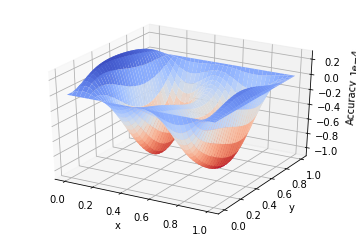

In [97]:
d_x=0.01
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1.0+d_x, d_x)
X, Y = np.meshgrid(x, y)

zs = np.array([psi_a(x,y,)-psi_t(x,y,p) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Accuracy')


plt.show()